# Total RMSE for performance assessment of ARPEGE-Climat PPE

<a id="top">This code</a> is combining the metric of four different variables (tas, pr, SW, LW) to create an aggretated metric $E_{tot}$ used for performance assessment and seleciton of an optimal sub-set of parametrizations. 

### [Step 1 - Emulator skill evaluation](#skill)
### [Figure histograms](#histograms)
### [Step 2 - Initial guess for optimization 1 ](#init1)
### [Step 3 - Optimisation 1 ](#optim1)
### [Step 4 - Initial guess for Optimization 2 (param. smoothing)](#init2)
### [Step 5 - Optimisation 2](#optim2)
### [Step 6 - Optimal subset of parameters](#selection)
### [Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3](#validation)
### [Step 8  - Feedback likelihood](#likelihood)

## Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

## Functions

In [2]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

# FONCTION MOYENNE NORMALISEE DES VARIABLES

def Norm_Average_df(Fdbck, variables, E_p1_df, name) :

    E_df = pd.DataFrame()
    E_df['Fdbck'] = Fdbck

    tmp = [0]*len(E_df) 

    for i in variables :
        E = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'+name+'_'+i+'.npy')
        E_df['RMSE_'+i] = E

        E_df['RMSE_'+i+'_norm'] = E_df['RMSE_'+i]/E_p1_df['E_p1_'+i]

        tmp = tmp + E_df['RMSE_'+i+'_norm']
    
    E_df['RMSE_total'] = tmp/len(variables)
    return E_df

In [3]:
def MultiLinReg_RMSE_skill_eval(limit_train, x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def function_RMSE_emulator_std_skill_eval(limit_train, x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_RMSE_skill_eval(limit_train,x, 1, variable)
    pc2 = MultiLinReg_RMSE_skill_eval(limit_train,x, 2, variable)
    pc3 = MultiLinReg_RMSE_skill_eval(limit_train,x, 3, variable)
    pc4 = MultiLinReg_RMSE_skill_eval(limit_train,x, 4, variable)
    pc5 = MultiLinReg_RMSE_skill_eval(limit_train,x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_total_skill_eval(limit_train, x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator_std_skill_eval(limit_train, x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E

In [4]:
# FONCTIONS FEEDBACKS

def em_fdb_std_skill_eval(limit_train, x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [5]:
# FUNCTIONS EMULATORS

def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

# FONCTIONS ERROR

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable =='tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

def function_RMSE_total(x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator(x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E
    

In [6]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1_'+variable+'.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2_'+variable+'.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3_'+variable+'.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4_'+variable+'.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5_'+variable+'.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1_'+variable+'.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2_'+variable+'.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3_'+variable+'.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4_'+variable+'.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5_'+variable+'.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac

# FONCTION JACOBIAN OF TOTAL ERROR

def jacobian_total(x, variables, E_p1_df) :
    
    tmp = 0
    for i in variables : 
        tmp0 = jacobian(x, i)/E_p1_df['E_p1_'+i]
        tmp = tmp + tmp0
    
    jac = tmp/len(variables)
    
    return jac

In [7]:
# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [8]:

# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variables, E_p1_df) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
        #if em_fdb(x0)<-1.8 : 
        #    ind = 0.0001
        #elif em_fdb(x0)>-1.0:
        #    ind = 0.0001
        #else:
        #    ind = 0.0001
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_total(x0, variables, E_p1_df)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_total,  x0, args=(variables, E_p1_df), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian_total, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_total(sol.x, variables, E_p1_df)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
        #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
        #    sol_list.append(tmp_fun)
        #    sol_fdbck.append(tmp_fdbck)
        #else :
        #    print('\n ERROR \n')
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [9]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

## Settings

In [10]:
variables = ['tas', 'pr', 'SW', 'LW']

variable_plot = 'total'
TITLE = 'Total'
ylabel = '$E_{tot}$ (no units)'

product = 'BEST'

## Get the data

### p1 default

In [11]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df = {}

for i in variables :
    E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+i+'.npy')
    E_p1_df['E_p1_'+i] = E_p1

E_p1_df

{'E_p1_tas': array(2.08017959),
 'E_p1_pr': array(1.99925075),
 'E_p1_SW': array(1.664249),
 'E_p1_LW': array(1.00782632)}

In [12]:
p1_feedbacks

array(-1.3328964)

In [13]:
E_p1_tmp = E_p1_df['E_p1_tas']/E_p1_df['E_p1_tas'] + E_p1_df['E_p1_pr']/E_p1_df['E_p1_pr'] + E_p1_df['E_p1_SW']/E_p1_df['E_p1_SW']+E_p1_df['E_p1_LW']/E_p1_df['E_p1_LW']
E_p1 = E_p1_tmp/4
E_p1

1.0

### CFMIP

In [14]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [15]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

MRI = {}
CAN = {}
MIROC = {}
HadGEM3 = {}
IPSL = {}
BCC = {}

for i in variables :
    
    if i == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'.npy')
    
    filename = 'U_MRI_'+i+'.npy'
    MRI[i] = Error(path, filename, U_obs)

    filename = 'U_CAN_'+i+'.npy'
    CAN[i] = Error(path, filename, U_obs)

    filename = 'U_MIROC_'+i+'.npy'
    MIROC[i] = Error(path, filename, U_obs)

    filename = 'U_HadGEM3_'+i+'.npy'
    HadGEM3[i] = Error(path, filename, U_obs)

    filename = 'U_IPSL_'+i+'.npy'
    IPSL[i] = Error(path, filename, U_obs)

    filename = 'U_BCC_'+i+'.npy'
    BCC[i] = Error(path, filename, U_obs)
    

E_MRI_tmp = MRI['tas']/E_p1_df['E_p1_tas'] + MRI['pr']/E_p1_df['E_p1_pr'] + MRI['SW']/E_p1_df['E_p1_SW']+MRI['LW']/E_p1_df['E_p1_LW']
E_MRI = E_MRI_tmp/4

E_CAN_tmp = CAN['tas']/E_p1_df['E_p1_tas'] + CAN['pr']/E_p1_df['E_p1_pr'] + CAN['SW']/E_p1_df['E_p1_SW']+CAN['LW']/E_p1_df['E_p1_LW']
E_CAN = E_CAN_tmp/4

E_MIROC_tmp = MIROC['tas']/E_p1_df['E_p1_tas'] + MIROC['pr']/E_p1_df['E_p1_pr'] + MIROC['SW']/E_p1_df['E_p1_SW']+MIROC['LW']/E_p1_df['E_p1_LW']
E_MIROC = E_MIROC_tmp/4

E_HadGEM3_tmp = HadGEM3['tas']/E_p1_df['E_p1_tas'] + HadGEM3['pr']/E_p1_df['E_p1_pr'] + HadGEM3['SW']/E_p1_df['E_p1_SW']+HadGEM3['LW']/E_p1_df['E_p1_LW']
E_HadGEM3 = E_HadGEM3_tmp/4

E_IPSL_tmp = IPSL['tas']/E_p1_df['E_p1_tas'] + IPSL['pr']/E_p1_df['E_p1_pr'] + IPSL['SW']/E_p1_df['E_p1_SW']+IPSL['LW']/E_p1_df['E_p1_LW']
E_IPSL = E_IPSL_tmp/4

E_BCC_tmp = BCC['tas']/E_p1_df['E_p1_tas'] + BCC['pr']/E_p1_df['E_p1_pr'] + BCC['SW']/E_p1_df['E_p1_SW']+BCC['LW']/E_p1_df['E_p1_LW']
E_BCC = E_BCC_tmp/4

In [16]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

### PPE

In [17]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

name = 'RMSE_PPE'
E_PPE_df = Norm_Average_df(Fdbck_PPE, variables, E_p1_df, name) 
E_PPE_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-0.825236,1.055966,0.507632,3.017001,1.509066,1.277445,0.767581,1.877673,1.863092,1.161843
1,-1.659636,2.821711,1.356475,2.442560,1.221738,1.789840,1.075464,1.984748,1.969336,1.405753
2,-1.215000,1.710921,0.822487,3.087427,1.544292,1.302026,0.782351,1.840896,1.826601,1.243933
3,-1.321641,2.530649,1.216553,2.531341,1.266145,1.963318,1.179702,2.448370,2.429357,1.522939
4,-0.750397,1.557580,0.748772,2.996862,1.498992,0.802075,0.481944,1.488861,1.477299,1.051752
...,...,...,...,...,...,...,...,...,...,...
97,-1.516367,2.522954,1.212854,2.493090,1.247012,2.020377,1.213987,1.841523,1.827223,1.375269
98,-1.584491,2.755906,1.324840,2.493093,1.247014,1.933462,1.161763,2.008353,1.992757,1.431593
99,-1.474525,2.746495,1.320316,2.452885,1.226902,1.733249,1.041460,1.668764,1.655805,1.311121
100,-1.445422,2.584486,1.242434,2.572920,1.286942,1.691045,1.016101,1.700071,1.686869,1.308087


In [18]:
E_PPE = E_PPE_df['RMSE_total'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable_plot+'.npy', E_PPE)

### Multi Lin Reg predictions

In [19]:
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
name = 'RMSE_multilinreg_pred'

E_multilinreg_df = Norm_Average_df(Fdbck_multilinreg_pred, variables, E_p1_df, name) 
E_multilinreg_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694
1,-1.339351,2.081600,1.000683,2.608792,1.304885,2.090596,1.256180,1.822507,1.808354,1.342525
2,-1.323732,2.055479,0.988126,2.371480,1.186184,1.715070,1.030537,1.608743,1.596250,1.200274
3,-1.541909,1.929926,0.927769,2.802809,1.401930,1.563995,0.939760,2.192307,2.175282,1.361185
4,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079
...,...,...,...,...,...,...,...,...,...,...
99995,-1.453679,2.522046,1.212418,2.097249,1.049017,2.578970,1.549630,1.642064,1.629313,1.360094
99996,-1.410350,2.338067,1.123973,3.071470,1.536310,2.084024,1.252231,1.194517,1.185241,1.274439
99997,-1.296397,1.954258,0.939466,2.422791,1.211849,1.277945,0.767881,1.656280,1.643418,1.140654
99998,-1.299809,2.251847,1.082525,2.590714,1.295843,1.365484,0.820480,1.283676,1.273708,1.118139


In [20]:
E_multilinreg = E_multilinreg_df['RMSE_total'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable_plot+'.npy', E_multilinreg)

### [Back to the top](#top)

# <a id="skill">Step 1 - Emulator skill evaluation</a> </li>

In [141]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

RMSE_skill_eval = []
for i in X :
    tmp = function_RMSE_total_skill_eval(80, i, variables, E_p1_df)
    RMSE_skill_eval.append(tmp)

Validation_RMSE_df = pd.DataFrame()
Validation_RMSE_df['RMSE_PPE_total'] = E_PPE_df['RMSE_total']
Validation_RMSE_df['RMSE_multilinreg_val_total'] = RMSE_skill_eval
Validation_RMSE_df

,RMSE_PPE_total,RMSE_multilinreg_val_total
0,1.161843,1.139815
1,1.405753,1.403343
2,1.243933,1.220692
3,1.522939,1.486155
4,1.051752,1.096907
...,...,...
97,1.375269,1.364983
98,1.431593,1.477164
99,1.311121,1.262445
100,1.308087,1.227704


In [142]:
sum_diff=0
cpt=0
Test_set = Validation_RMSE_df[80:]
for i in Test_set['RMSE_multilinreg_val_total'] :
    j = Test_set['RMSE_PPE_total'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set)
OSE_Etot = sqrt(sum_diff/n)
OSE_Etot
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy', OSE_total)

In [143]:
r_test = np.corrcoef(Test_set['RMSE_multilinreg_val_total'], Test_set['RMSE_PPE_total'])
r_test

array([[1.        , 0.85630331],
       [0.85630331, 1.        ]])

In [144]:
r_full = np.corrcoef(Validation_RMSE_df['RMSE_multilinreg_val_total'], Validation_RMSE_df['RMSE_PPE_total'])
r_full

array([[1.        , 0.85930528],
       [0.85930528, 1.        ]])

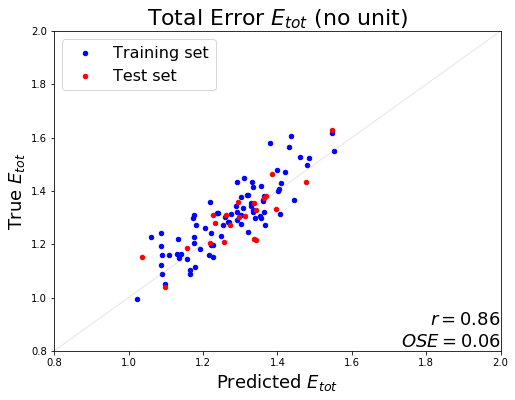

In [145]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"
Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.06$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.86$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.8,2)
plt.xlim(0.8,2)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [27]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

Fdbck_skill_eval = []
for i in X :
    tmp = em_fdb_std_skill_eval(80, i)
    Fdbck_skill_eval.append(tmp)

Validation_fdbck_df = pd.DataFrame()
Validation_fdbck_df['Fdbck_PPE'] = E_PPE_df['Fdbck']
Validation_fdbck_df['Fdbck_multilinreg_val'] = Fdbck_skill_eval
Validation_fdbck_df

,Fdbck_PPE,Fdbck_multilinreg_val
0,-0.825236,-1.180536
1,-1.659636,-1.594507
2,-1.215000,-1.068508
3,-1.321641,-1.363567
4,-0.750397,-1.140111
...,...,...
97,-1.516367,-1.550227
98,-1.584491,-1.635200
99,-1.474525,-1.418686
100,-1.445422,-1.621942


In [146]:
sum_diff=0
cpt=0
Test_set_fdbck = Validation_fdbck_df[80:]
for i in Test_set_fdbck['Fdbck_multilinreg_val'] :
    j = Test_set_fdbck['Fdbck_PPE'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_fdbck = sqrt(sum_diff/n)
OSE_fdbck

NameError: name 'Validation_fdbck_df' is not defined

In [147]:
r_test = np.corrcoef(Test_set_fdbck['Fdbck_multilinreg_val'], Test_set_fdbck['Fdbck_PPE'])
r_test

NameError: name 'Test_set_fdbck' is not defined

In [148]:
r_full = np.corrcoef(Validation_fdbck_df['Fdbck_multilinreg_val'], Validation_fdbck_df['Fdbck_PPE'])
r_full

NameError: name 'Validation_fdbck_df' is not defined

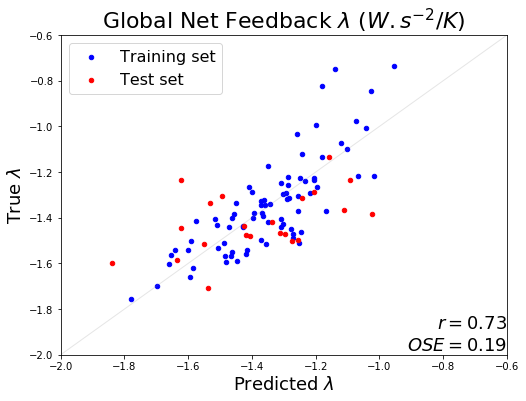

In [33]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.73$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.0,-0.6)
plt.xlim(-2.0,-0.6)
ax.plot((-2.0,-0.6), (-2.0,-0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [21]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable_plot+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [22]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable_plot+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [23]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.107454,0.886597
1,-1.111439,0.989970
2,-1.166431,0.983043
3,-1.189483,0.999646
4,-1.213516,0.952113
...,...,...
1078,-1.189431,0.984514
1079,-1.449989,0.998578
1080,-1.090233,0.939935
1081,-1.148633,0.989246


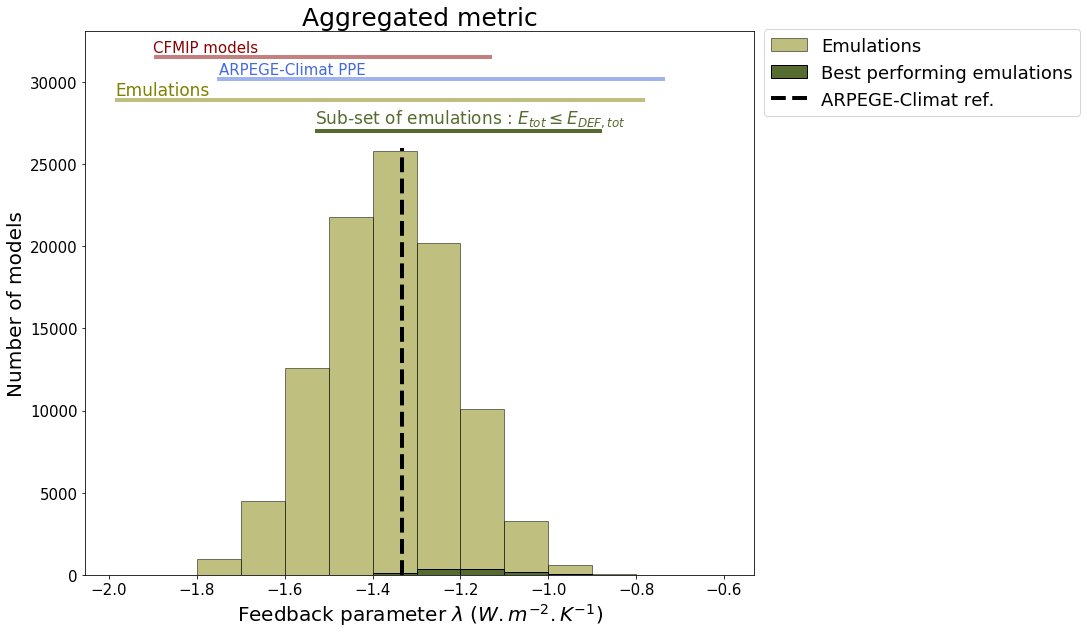

In [38]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'ARPEGE-Climat PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{tot}\leq E_{DEF,tot}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'ARPEGE-Climat ref.']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title('Aggregated metric', fontsize = 25)
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable_plot+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [33]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable_plot+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [34]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

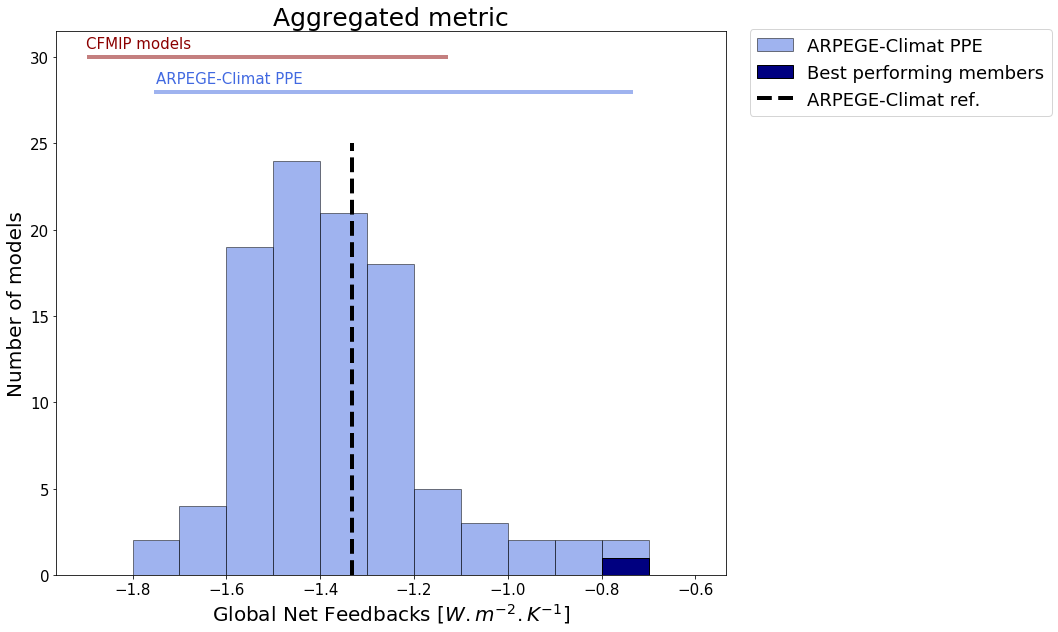

In [37]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'ARPEGE-Climat PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
#plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{tot}\leq E_{DEF,tot}$', 
#         color = 'navy', fontsize=17)

legend=['ARPEGE-Climat PPE', 'Best performing members', 'ARPEGE-Climat ref.']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title('Aggregated metric', fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable_plot+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="init1">Step 2 - Initial guess for optimization 1</a> </li> 

In [21]:
E_multilinreg_df['Fdbck_round'] = E_multilinreg_df['Fdbck'].round(decimals=2)
E_multilinreg_df = E_multilinreg_df.set_index('Fdbck_round')
E_multilinreg_df['members'] = range(0,100000,1) 
E_multilinreg_df        

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,members
Fdbck_round,,,,,,,,,,,
-1.50,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694,0
-1.34,-1.339351,2.081600,1.000683,2.608792,1.304885,2.090596,1.256180,1.822507,1.808354,1.342525,1
-1.32,-1.323732,2.055479,0.988126,2.371480,1.186184,1.715070,1.030537,1.608743,1.596250,1.200274,2
-1.54,-1.541909,1.929926,0.927769,2.802809,1.401930,1.563995,0.939760,2.192307,2.175282,1.361185,3
-1.35,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079,4
...,...,...,...,...,...,...,...,...,...,...,...
-1.45,-1.453679,2.522046,1.212418,2.097249,1.049017,2.578970,1.549630,1.642064,1.629313,1.360094,99995
-1.41,-1.410350,2.338067,1.123973,3.071470,1.536310,2.084024,1.252231,1.194517,1.185241,1.274439,99996
-1.30,-1.296397,1.954258,0.939466,2.422791,1.211849,1.277945,0.767881,1.656280,1.643418,1.140654,99997


In [22]:
new_df=pd.DataFrame()
new_df['RMSE_total_best'] = E_multilinreg_df['RMSE_total'].groupby('Fdbck_round').min()
new_df = new_df.reset_index()
new_df

,Fdbck_round,RMSE_total_best
0,-1.99,1.462776
1,-1.95,1.570563
2,-1.93,1.550210
3,-1.91,1.719126
4,-1.90,1.412999
...,...,...
108,-0.86,1.068000
109,-0.85,1.039543
110,-0.82,1.265035
111,-0.80,1.119955


In [23]:
list_RMSE = new_df['RMSE_total_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_df['RMSE_total'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_df['Fdbck'].iloc[cpt])
            tmp_member.append(E_multilinreg_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df

,Fdbck_round,RMSE_total_best,Fdbck,members
0,-1.99,1.462776,-1.985956,35649
1,-1.95,1.570563,-1.953341,47523
2,-1.93,1.550210,-1.927200,30599
3,-1.91,1.719126,-1.914973,74150
4,-1.90,1.412999,-1.902838,2836
...,...,...,...,...
108,-0.86,1.068000,-0.858778,47299
109,-0.85,1.039543,-0.852741,60906
110,-0.82,1.265035,-0.820649,57260
111,-0.80,1.119955,-0.803475,76973


In [24]:
# CHECK OBJECTIVE FUNCTION

#x = x_best[4]
#y = function_RMSE_total(x, variables, E_p1_df)
#print(y)

### [Back to the top](#top)

# <a id="optim1">Step 3 - Optimization 1</a> </li> 

In [25]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [26]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

In [27]:
sol_df = Optimization(x_best, 0.0001, xlim, variables, E_p1_df)
sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3731218175678506
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3396743951839782
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3860304786563897
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4743646393455696
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3520811317757937
            Iterations: 3
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0103226214843541
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9988478675721598
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9982604598198865
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9789640702134711
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.99608929755411
            Iterations: 1
            Function evaluation

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8636577026236752
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.846354417301672
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8314949657150841
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.886230498485773
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8451115055358196
            Iterations: 4
            Function evaluation

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.373122,-1.985856,0.146328,0.780123,1.444684,29.576979,-0.010000,7.192002,2.930062,0.000500,...,-2.442927,-25.204835,0.080632,13.397145,0.00001,0.786024,0.500000,0.644483,0.500000,5.629951
1,1.339674,-1.953241,0.103968,0.555650,1.977367,18.665510,-0.010001,6.397880,5.605659,0.000500,...,-2.465445,-30.728271,0.033462,17.980191,0.00001,0.851015,0.500000,0.641068,0.500000,2.982851
2,1.386030,-1.927100,0.189685,0.643129,0.547278,26.910914,-0.010000,6.609505,1.626301,0.000500,...,-1.691429,-49.463711,0.100000,9.123536,0.00001,0.749118,0.608807,0.944534,0.500000,6.803010
3,1.474365,-1.914873,0.146196,0.715399,1.579878,18.203564,-0.010000,7.489183,0.500996,0.000500,...,-1.772653,-40.622150,0.069977,2.107134,0.00001,0.695196,0.570108,0.761770,0.500000,1.074819
4,1.352081,-1.902738,0.130721,0.843340,1.133767,28.889529,-0.021387,6.647126,7.044549,0.000500,...,-4.432943,-27.337151,0.031858,16.169500,0.00001,0.933671,0.540615,0.919134,0.530172,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.897553,-0.858878,0.228312,2.405269,0.718819,19.330727,-0.341955,3.110003,5.011374,0.004398,...,-2.609538,-27.189283,0.010000,1.807595,0.00010,0.678653,0.500896,0.878138,0.875084,4.265085
109,0.795182,-0.852826,0.180365,2.527689,0.927785,14.601003,-0.058889,1.510372,7.903602,0.003298,...,-2.600770,-49.550141,0.010000,0.126513,0.00010,0.717584,0.813763,0.895958,0.792650,6.069909
110,1.120510,-0.820749,0.188924,2.526458,0.549320,17.649293,-0.366278,0.253844,4.374101,0.006245,...,-1.151038,-25.747210,0.010000,1.335892,0.00010,0.645745,0.500000,1.000000,0.766429,1.562748
111,1.045339,-0.803575,0.218522,2.346404,1.617868,21.203356,-0.118813,0.186077,4.020097,0.004918,...,-2.832096,-44.686306,0.010000,5.183731,0.00010,0.872569,0.820054,0.630818,0.831695,1.272176


### Plotting

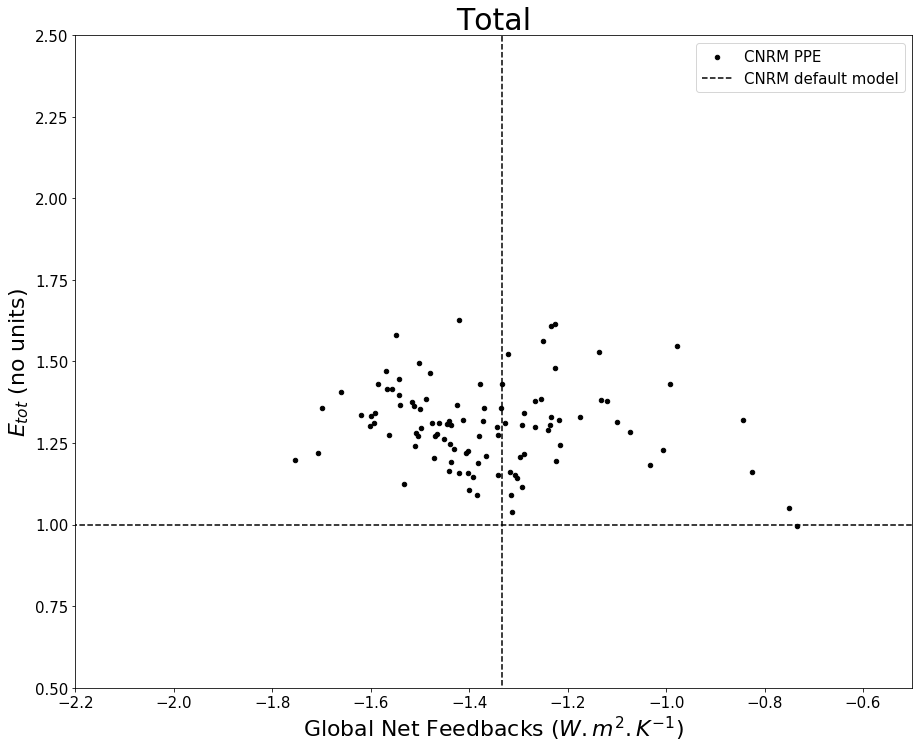

In [28]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_only.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

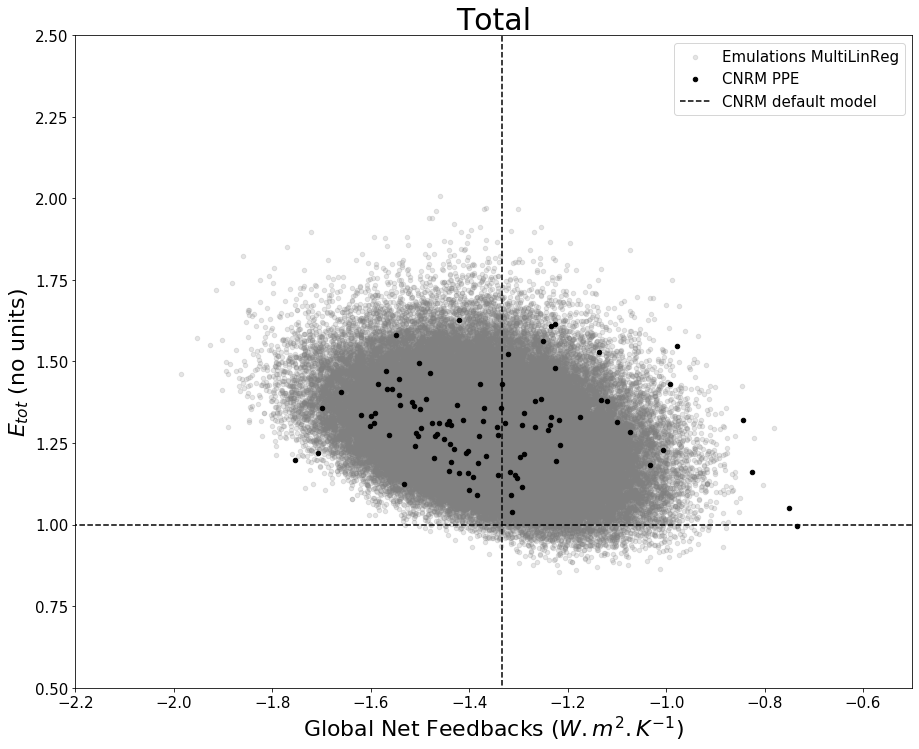

In [29]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

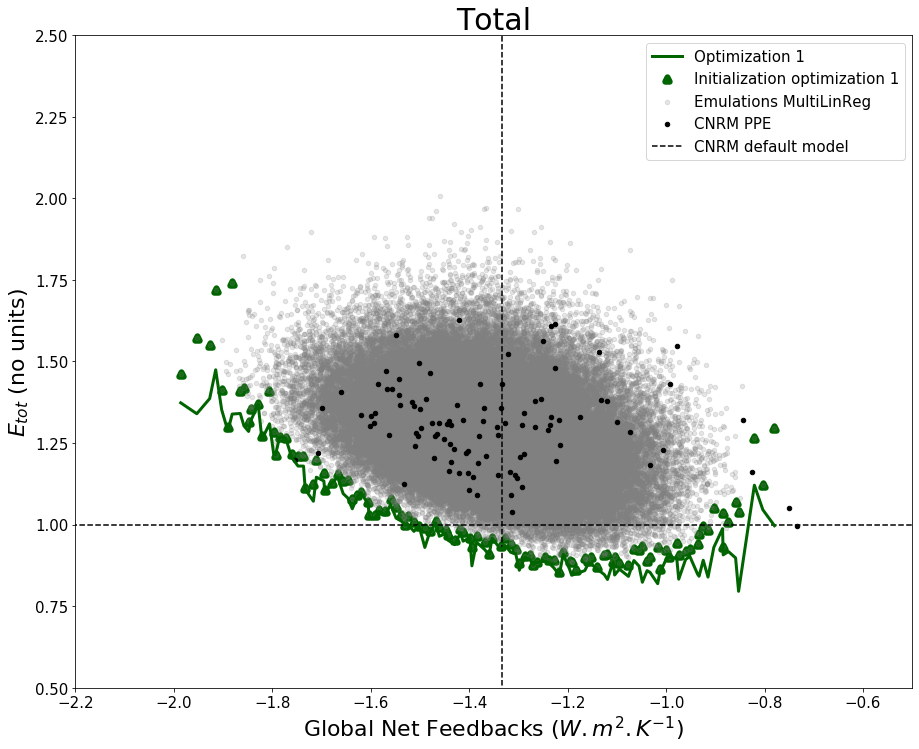

In [30]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

#  <a id="init2">Step 4 - Initial guess for Optimization 2 (param. smoothing)</a> </li> 

In [31]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.146328,0.780123,1.444684,29.576979,-0.010000,7.192002,2.930062,0.000500,0.001000,...,-2.442927,-25.204835,0.080632,13.397145,0.000010,0.786024,0.500000,0.644483,0.500000,5.629951
1,-1.953241,0.135987,0.633638,1.486674,23.454728,-0.010000,6.649317,3.941920,0.000500,0.001000,...,-2.536930,-26.032426,0.079284,13.377248,0.000011,0.783607,0.515031,0.654106,0.503794,5.411061
2,-1.927100,0.157383,0.639327,1.162951,22.672725,-0.010000,6.776518,2.339814,0.000500,0.001000,...,-2.629381,-26.845831,0.077946,13.354413,0.000012,0.781320,0.529942,0.663618,0.507601,5.197270
3,-1.914873,0.153200,0.729317,1.210201,23.051893,-0.012847,7.058749,2.418211,0.000500,0.001000,...,-2.718770,-27.631453,0.076624,13.325847,0.000013,0.779287,0.544616,0.672913,0.511432,4.993430
4,-1.902738,0.130661,0.740995,1.397432,23.046153,-0.038785,6.245884,3.802886,0.000545,0.000907,...,-2.803679,-28.376846,0.075326,13.289040,0.000014,0.777628,0.558944,0.681894,0.515294,4.803927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.858878,0.206291,2.359970,1.263503,14.447604,-0.207009,2.541688,4.685905,0.003887,0.000225,...,-2.624747,-44.874929,0.010513,7.499868,0.000094,0.560260,0.550456,0.939508,0.817253,6.539819
109,-0.852826,0.194491,2.496776,0.780927,16.545506,-0.206503,1.596148,6.298170,0.004310,0.000207,...,-2.597835,-45.473194,0.010380,7.954587,0.000095,0.551876,0.544822,0.951051,0.828765,6.833205
110,-0.820749,0.194184,2.481752,0.911073,17.775736,-0.227565,0.551034,5.167975,0.005177,0.000141,...,-2.569046,-46.096958,0.010251,8.428035,0.000097,0.543171,0.539112,0.962707,0.840546,7.137311
111,-0.803575,0.216446,2.468419,1.221249,22.362161,-0.248434,0.590087,4.666637,0.004894,0.000069,...,-2.538986,-46.738443,0.010125,8.914365,0.000098,0.534245,0.533350,0.974441,0.852514,7.448802


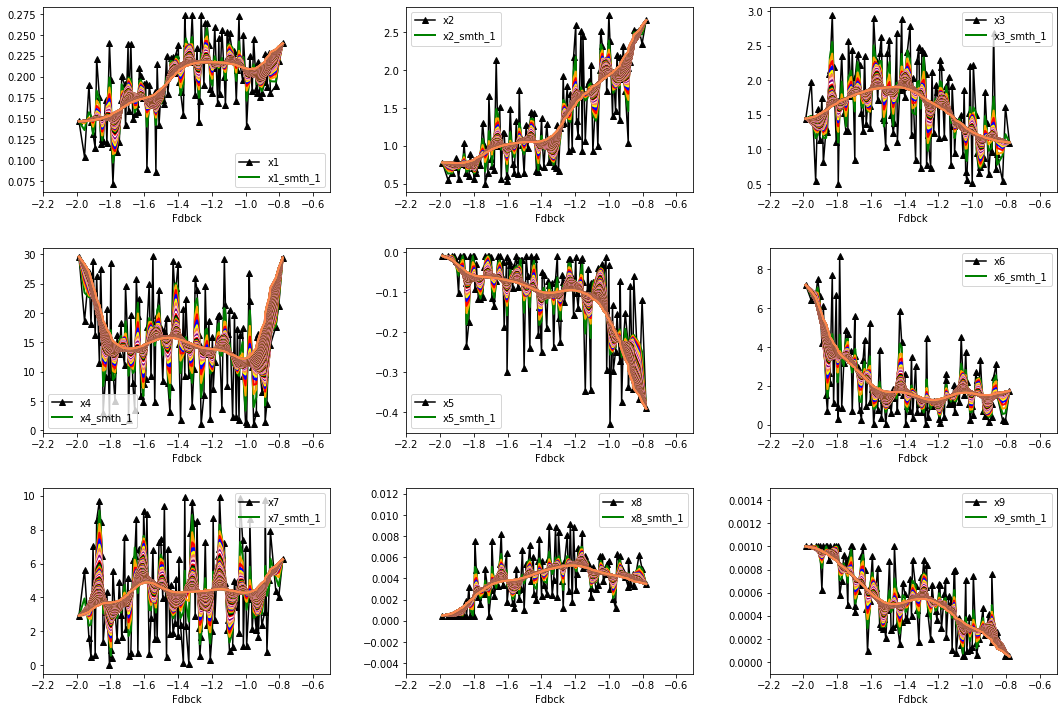

In [32]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

# <a id="optim2">Step 5 - Optimisation 2</a> </li> 

In [33]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.14632843, 0.78012258, 1.44468399, ..., 0.64448321, 0.5       ,
        5.62995092],
       [0.14672048, 0.7781926 , 1.46183521, ..., 0.65410578, 0.50379372,
        5.41106149],
       [0.14711347, 0.77643331, 1.47898395, ..., 0.66361757, 0.50760059,
        5.19726952],
       ...,
       [0.23268994, 2.52631933, 1.11486925, ..., 0.96270744, 0.84054608,
        7.13731104],
       [0.23622295, 2.58997009, 1.10742287, ..., 0.97444131, 0.85251381,
        7.44880203],
       [0.23981492, 2.6544088 , 1.09994014, ..., 0.9862143 , 0.86457739,
        7.76405946]])

In [34]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_total(i, variables, E_p1_df)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,1.373122
1,-1.953241,1.359809
2,-1.927100,1.346774
3,-1.914873,1.334014
4,-1.902738,1.321515
...,...,...
108,-0.858878,0.899062
109,-0.852826,0.919978
110,-0.820749,0.943311
111,-0.803575,0.968859


In [35]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variables, E_p1_df)
sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3731220527643178
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3598095592586374
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3467736639072079
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3340140468133022
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.321515253438867
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9783466662191425
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.972209332521647
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9662099565100657
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9603512432657895
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9546370634793618
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.821122601354495
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8191433590196824
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8172768762819093
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8155273693362965
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8138978460596271
            Iterations: 2
            Function evaluati

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,-2.442926,-25.204834,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949
1,1.359810,-1.971674,0.146720,0.778192,1.461834,28.319027,-0.014766,6.881128,3.040107,0.000604,...,-2.536930,-26.032426,0.079284,13.377247,0.000011,0.783607,0.515031,0.654106,0.503794,5.411061
2,1.346774,-1.957546,0.147113,0.776433,1.478984,27.072353,-0.019480,6.573405,3.147039,0.000709,...,-2.629381,-26.845830,0.077945,13.354413,0.000012,0.781320,0.529942,0.663618,0.507601,5.197269
3,1.334014,-1.943522,0.147509,0.775013,1.496122,25.847982,-0.024090,6.271872,3.247944,0.000816,...,-2.718770,-27.631453,0.076624,13.325847,0.000013,0.779287,0.544616,0.672913,0.511432,4.993430
4,1.321515,-1.929651,0.147910,0.774095,1.513233,24.656438,-0.028547,5.979370,3.340289,0.000926,...,-2.803679,-28.376846,0.075326,13.289040,0.000014,0.777628,0.558944,0.681894,0.515294,4.803927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.892546,-0.834363,0.224683,2.399528,1.126384,22.751786,-0.322544,1.598383,5.482885,0.003909,...,-2.624335,-44.873432,0.010462,7.497904,0.000094,0.560141,0.548635,0.940089,0.813889,6.536863
109,0.912772,-0.820918,0.227849,2.459231,1.119100,24.332377,-0.338195,1.627775,5.666081,0.003848,...,-2.597429,-45.471671,0.010342,7.952478,0.000096,0.551779,0.543004,0.951620,0.825325,6.830221
110,0.935426,-0.807335,0.231179,2.521174,1.111733,25.980034,-0.354240,1.660023,5.856853,0.003784,...,-2.568644,-46.095408,0.010226,8.425774,0.000097,0.543097,0.537297,0.963265,0.837026,7.134295
111,0.960328,-0.793656,0.234621,2.584659,1.104300,27.673832,-0.370560,1.694241,6.052813,0.003718,...,-2.538591,-46.736864,0.010112,8.911949,0.000099,0.534194,0.531538,0.974987,0.848913,7.445753


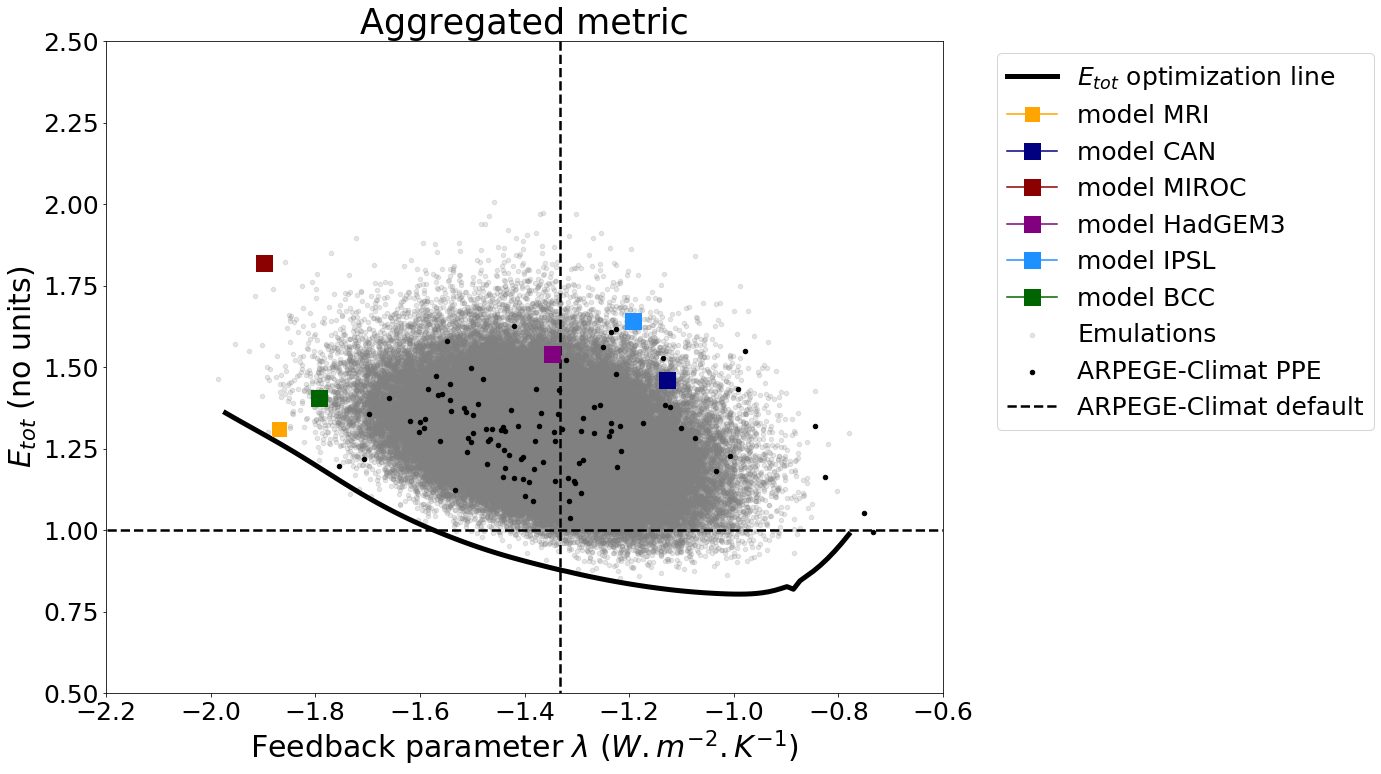

In [36]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{tot}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title('Aggregated metric', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [135]:
RMSE_optim2 = sol_df_2#['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable_plot+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable_plot+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

In [32]:
df_select = sol_df_2[sol_df_2.index % 15 == 0]
df_select = df_select.append(sol_df_2.iloc[len(sol_df_2)-1])
df_select

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,-2.442926,-25.204834,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949
15,1.193206,-1.793592,0.154964,0.829713,1.684986,15.663434,-0.058919,3.772202,3.706411,0.002345,...,-3.223534,-32.375456,0.062870,12.147488,0.000028,0.800522,0.674975,0.748056,0.555485,4.091355
30,1.048298,-1.639310,0.172008,0.998078,1.836255,14.147628,-0.067522,2.431632,4.685189,0.003715,...,-2.866823,-31.997047,0.050568,10.558879,0.000042,0.845763,0.700214,0.787240,0.571370,3.943705
45,0.949071,-1.490135,0.187056,1.049564,1.897214,15.680008,-0.084573,1.687823,4.563052,0.004141,...,-2.408662,-34.082861,0.040417,9.367938,0.000054,0.797717,0.669655,0.819201,0.569827,3.135282
60,0.880881,-1.339147,0.213392,1.131578,1.824348,14.942521,-0.100576,1.495156,4.325799,0.004902,...,-2.426605,-35.868917,0.029625,7.977232,0.000065,0.769279,0.640255,0.802243,0.580469,3.035895
75,0.832549,-1.188858,0.216162,1.567546,1.597528,13.813212,-0.094207,1.315960,4.458222,0.005092,...,-2.419845,-37.235084,0.021431,5.522517,0.000075,0.725725,0.631811,0.787272,0.626424,3.584113
90,0.806626,-1.039423,0.211577,1.865591,1.315575,12.362809,-0.137797,1.645616,4.315073,0.004537,...,-2.560147,-39.592808,0.014479,4.221725,0.000079,0.641830,0.621811,0.791488,0.671610,4.101077
105,0.844799,-0.873522,0.215917,2.236857,1.145958,18.581431,-0.277195,1.531549,4.998267,0.004118,...,-2.688058,-43.289075,0.010800,6.292880,0.000091,0.582428,0.563790,0.906879,0.779915,5.746180
112,0.987190,-0.779930,0.238120,2.648930,1.096830,29.391139,-0.387021,1.729465,6.251407,0.003651,...,-2.507897,-47.387403,0.010000,9.404685,0.000100,0.525178,0.525752,0.986748,0.860895,7.760977


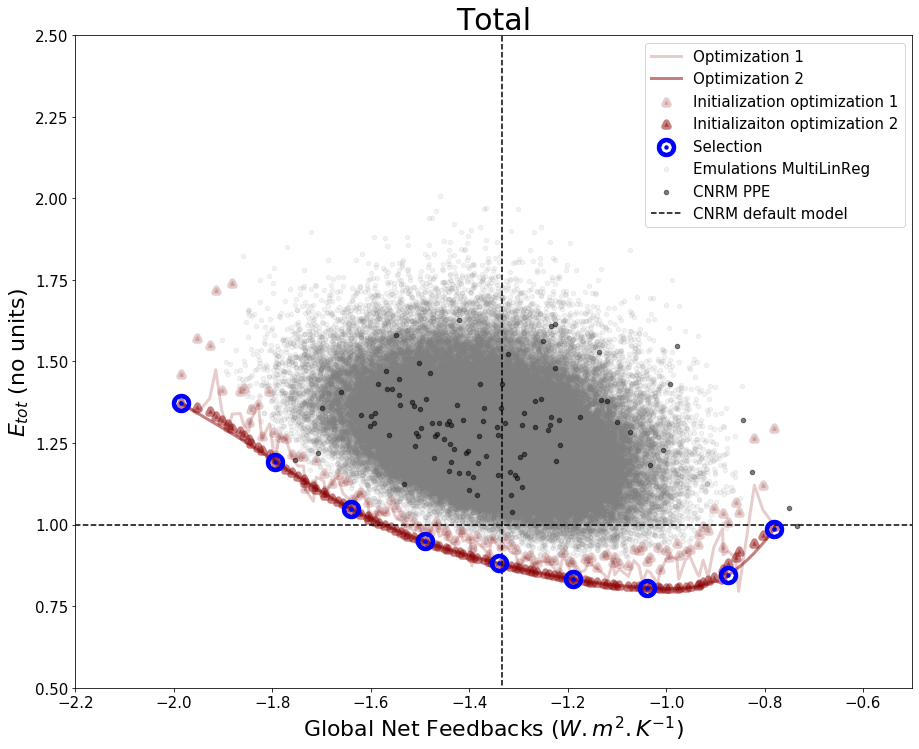

In [31]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.5,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.5, linewidth=3, ax = ax)

df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Selection', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [32]:
list_index = df_select.columns.tolist()
list_index

['sol_fun',
 'Fdbck',
 'x1_smth_0',
 'x2_smth_0',
 'x3_smth_0',
 'x4_smth_0',
 'x5_smth_0',
 'x6_smth_0',
 'x7_smth_0',
 'x8_smth_0',
 'x9_smth_0',
 'x10_smth_0',
 'x11_smth_0',
 'x12_smth_0',
 'x13_smth_0',
 'x14_smth_0',
 'x15_smth_0',
 'x16_smth_0',
 'x17_smth_0',
 'x18_smth_0',
 'x19_smth_0',
 'x20_smth_0',
 'x21_smth_0',
 'x22_smth_0',
 'x23_smth_0',
 'x24_smth_0',
 'x25_smth_0',
 'x26_smth_0',
 'x27_smth_0',
 'x28_smth_0',
 'x29_smth_0',
 'x30_smth_0']

### Save the data

In [33]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy', df_select)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select_indexes.npy', list_index)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy', sol_df_2)

In [42]:
df_select_tmp = df_select.drop(['sol_fun', 'Fdbck'], axis=1)

#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_BIS_optim2_param.txt', df_select_tmp.values)
np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_TER_optim2_param.txt', df_select_tmp.values)

### [Back to the top](#top)

# <a id="validation">Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3</a> </li>

### Settings

In [21]:
nb_p_list_selection = ['p810', 'p812', 'p813', 'p814','p815', 'p816', 'p817']
len(nb_p_list_selection)

7

In [22]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([1, 8])
df_select['sol_fun'] = df_select[0]
df_select['Fdbck'] = df_select[1]
df_select = df_select
df_select

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949,1.373122,-1.985856
2,1.048298,-1.639310,0.172008,0.998078,1.836255,14.147628,-0.067522,2.431632,4.685189,0.003715,...,0.050568,10.558879,0.000042,0.845763,0.700214,0.787240,0.571370,3.943705,1.048298,-1.639310
3,0.949071,-1.490135,0.187056,1.049564,1.897214,15.680008,-0.084573,1.687823,4.563052,0.004141,...,0.040417,9.367938,0.000054,0.797717,0.669655,0.819201,0.569827,3.135282,0.949071,-1.490135
4,0.880881,-1.339147,0.213392,1.131578,1.824348,14.942521,-0.100576,1.495156,4.325799,0.004902,...,0.029625,7.977232,0.000065,0.769279,0.640255,0.802243,0.580469,3.035895,0.880881,-1.339147
5,0.832549,-1.188858,0.216162,1.567546,1.597528,13.813212,-0.094207,1.315960,4.458222,0.005092,...,0.021431,5.522517,0.000075,0.725725,0.631811,0.787272,0.626424,3.584113,0.832549,-1.188858
6,0.806626,-1.039423,0.211577,1.865591,1.315575,12.362809,-0.137797,1.645616,4.315073,0.004537,...,0.014479,4.221725,0.000079,0.641830,0.621811,0.791488,0.671610,4.101077,0.806626,-1.039423
7,0.844799,-0.873522,0.215917,2.236857,1.145958,18.581431,-0.277195,1.531549,4.998267,0.004118,...,0.010800,6.292880,0.000091,0.582428,0.563790,0.906879,0.779915,5.746180,0.844799,-0.873522


In [23]:
df_crashed = pd.DataFrame(file).drop([0, 2,3,4,5,6,7])
df_crashed['sol_fun']=df_crashed[0]
df_crashed['Fdbck']=df_crashed[1]
df_crashed

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
1,1.193206,-1.793592,0.154964,0.829713,1.684986,15.663434,-0.058919,3.772202,3.706411,0.002345,...,0.06287,12.147488,0.000028,0.800522,0.674975,0.748056,0.555485,4.091355,1.193206,-1.793592
8,0.987190,-0.779930,0.238120,2.648930,1.096830,29.391139,-0.387021,1.729465,6.251407,0.003651,...,0.01000,9.404685,0.000100,0.525178,0.525752,0.986748,0.860895,7.760977,0.987190,-0.779930


In [24]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable_plot+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable_plot+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,sol_fun,Fdbck
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949,1.373122,-1.985856,1.373122,-1.985856
1,1.359810,-1.971674,0.146720,0.778192,1.461834,28.319027,-0.014766,6.881128,3.040107,0.000604,...,0.000011,0.783607,0.515031,0.654106,0.503794,5.411061,1.359810,-1.971674,1.359810,-1.971674
2,1.346774,-1.957546,0.147113,0.776433,1.478984,27.072353,-0.019480,6.573405,3.147039,0.000709,...,0.000012,0.781320,0.529942,0.663618,0.507601,5.197269,1.346774,-1.957546,1.346774,-1.957546
3,1.334014,-1.943522,0.147509,0.775013,1.496122,25.847982,-0.024090,6.271872,3.247944,0.000816,...,0.000013,0.779287,0.544616,0.672913,0.511432,4.993430,1.334014,-1.943522,1.334014,-1.943522
4,1.321515,-1.929651,0.147910,0.774095,1.513233,24.656438,-0.028547,5.979370,3.340289,0.000926,...,0.000014,0.777628,0.558944,0.681894,0.515294,4.803927,1.321515,-1.929651,1.321515,-1.929651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.892546,-0.834363,0.224683,2.399528,1.126384,22.751786,-0.322544,1.598383,5.482885,0.003909,...,0.000094,0.560141,0.548635,0.940089,0.813889,6.536863,0.892546,-0.834363,0.892546,-0.834363
109,0.912772,-0.820918,0.227849,2.459231,1.119100,24.332377,-0.338195,1.627775,5.666081,0.003848,...,0.000096,0.551779,0.543004,0.951620,0.825325,6.830221,0.912772,-0.820918,0.912772,-0.820918
110,0.935426,-0.807335,0.231179,2.521174,1.111733,25.980034,-0.354240,1.660023,5.856853,0.003784,...,0.000097,0.543097,0.537297,0.963265,0.837026,7.134295,0.935426,-0.807335,0.935426,-0.807335
111,0.960328,-0.793656,0.234621,2.584659,1.104300,27.673832,-0.370560,1.694241,6.052813,0.003718,...,0.000099,0.534194,0.531538,0.974987,0.848913,7.445753,0.960328,-0.793656,0.960328,-0.793656


### Error estimate

In [25]:
PC_PPE_selection = {}

for j in variables :
    for i in nb_p_list_selection :
        PC_PPE_selection[i+'_'+j] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+j+'.npy')
    
PC_PPE_selection

{'p810_tas': array([ 0.57293427,  0.57497543,  1.9732208 , -2.005266  , -0.15298209],
       dtype=float32),
 'p812_tas': array([ 0.6821011 , -1.2283556 ,  0.89717203,  0.5717874 ,  2.6210186 ],
       dtype=float32),
 'p813_tas': array([ 0.5423005 , -1.640776  ,  1.1919888 ,  0.42733228,  4.0932264 ],
       dtype=float32),
 'p814_tas': array([ 0.1216846, -1.6245865,  0.308921 ,  1.2732401,  3.4068518],
       dtype=float32),
 'p815_tas': array([ 0.3294735 , -0.6668262 , -0.08333512,  1.3133837 ,  1.2312343 ],
       dtype=float32),
 'p816_tas': array([ 0.38478947, -0.8811011 , -0.79679793,  2.100965  ,  0.16142665],
       dtype=float32),
 'p817_tas': array([ 0.84573025, -1.189559  , -0.22602774,  0.21725208,  2.1442702 ],
       dtype=float32),
 'p810_pr': array([2.35370413, 0.67323379, 1.25654732, 2.33760318, 2.67917166]),
 'p812_pr': array([ 1.04894674,  0.3873057 , -0.04808974, -0.32560068,  2.60030817]),
 'p813_pr': array([ 0.61796212,  0.33963731, -0.1300951 , -0.10541891,  1.7

In [26]:
E_PPE_selection = {}

for j in variables :
    list_tmp = []
    for i in nb_p_list_selection :
        pc1 = PC_PPE_selection[i+'_'+j][0]
        pc2 = PC_PPE_selection[i+'_'+j][1]
        pc3 = PC_PPE_selection[i+'_'+j][2]
        pc4 = PC_PPE_selection[i+'_'+j][3]
        pc5 = PC_PPE_selection[i+'_'+j][4]
    
        list_tmp.append(Error_emulator(pc1, pc2, pc3, pc4, pc5, j))
    E_PPE_selection[j] = list_tmp

E_PPE_selection

{'tas': [2.7166715832228876,
  0.8930138007642927,
  0.8296358365233248,
  0.32092738853862657,
  1.2203496936814204,
  1.7136119427696155,
  1.0490988083642743],
 'pr': [3.1047813045082133,
  3.2395597948783643,
  2.8731500139740476,
  3.1106122734832957,
  3.1428954270740306,
  2.8403041037527537,
  2.2588369457429214],
 'SW': [1.17661785556538,
  1.2199369018285355,
  1.1374327689530974,
  0.9065073367047461,
  0.7477110411605229,
  1.1592498751794613,
  1.8716183268865334],
 'LW': [1.4239568061577397,
  1.3111904489356572,
  1.4737469487658703,
  1.1441608402208332,
  1.0448491525301886,
  1.147706016785555,
  1.2004128253000586]}

In [27]:
E_PPE_selection_total=[0]*len(E_PPE_selection['tas'])

for i in range(0,len(E_PPE_selection['tas']),1) :
    E_PPE_selection_total[i] = E_PPE_selection['tas'][i]/E_p1_df['E_p1_tas']+E_PPE_selection['pr'][i]/E_p1_df['E_p1_pr']+E_PPE_selection['SW'][i]/E_p1_df['E_p1_SW']+E_PPE_selection['LW'][i]/E_p1_df['E_p1_LW']
    E_PPE_selection_total[i] = E_PPE_selection_total[i]/4

E_PPE_selection_total

[1.244711769309612,
 1.0209293105386579,
 0.9954239790129388,
 0.8475345136228492,
 0.911176563018458,
 1.0199547152430066,
 0.9874664844831649]

In [28]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/Net_feedbacks.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection

[-1.7816104888916016,
 -1.6676394542058308,
 -1.5599131186803181,
 -1.435193657875061,
 -1.0590825080871582,
 -0.7046475211779276,
 -0.6437352299690247]

# <a id="likelihood">Likelihood</a> </li>

In [29]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

CFMIP_list = ['MRI', 'CAN', 'MIROC', 'HadGEM3', 'IPSL', 'BCC']

In [30]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df

{'E_p1_tas': array(2.08017959),
 'E_p1_pr': array(1.99925075),
 'E_p1_SW': array(1.664249),
 'E_p1_LW': array(1.00782632)}

In [31]:
Likelihood_df = pd.DataFrame()
variables = ['tas', 'pr', 'SW', 'LW']

#OSE_tmp=0
#E1_tmp = 0
#tmp1=0
#tmp2=0
#for j in variables :
#    tmp1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+j+'.npy')
#    OSE_tmp = OSE_tmp + tmp1
#
#    tmp2 = E_p1_df['E_p1_'+j]
#    E1_tmp = E1_tmp + tmp2
    
#OSE_total = OSE_tmp/len(variables)
#E_p1_df['E_p1_total'] = E1_tmp/len(variables)
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy', OSE_total)


#variables = ['tas', 'pr', 'SW','LW', 'total']
RMSE_optim2={}
Fdbck_optim2={}
for i in variables :
    RMSE_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
    Fdbck_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')
    OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+i+'.npy')
    print(OSE)
    
    E_p1_tmp = E_p1_df['E_p1_'+i]
    L = []
    cpt=0
    for j in RMSE_optim2[i] :
        tmp = exp(-(j)/(2*OSE))
        tmp_2 = tmp#/(sqrt(OSE))#*1/100
        cpt+=1
        L.append(tmp_2)


    Likelihood_df['Fdbck_'+i] = Fdbck_optim2[i]
    Likelihood_df['Fdbck_likelihood_'+i] = L
    
    scale = Likelihood_df['Fdbck_likelihood_'+i].max()
    like = []
    for k in Likelihood_df['Fdbck_likelihood_'+i] : 
        tmp = k/scale
        like.append(tmp)
    Likelihood_df['Fdbck_likelihood_'+i] = like
    
#i=['total']
#tmp = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
#RMSE_optim2[i] = tmp[0]
#Fdbck_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')
#OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+i+'.npy')
    
#E_p1_tmp = E_p1['E_p1_'+i]
#L = []
#for j in RMSE_optim2[i] :
#    tmp = exp(-(j-E_p1_tmp)/(2*OSE))
#    tmp_2 = tmp/sqrt(OSE)*1/100
#    L.append(tmp_2)


#Likelihood_df['Fdbck_'+i] = Fdbck_optim2[i]
#Likelihood_df['Fdbck_likelihood_'+i] = L


#Likelihood_df['Fdbck_total'] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_total.npy')
#Likelihood_df['Fdbck_likelihood_total'] = (Likelihood_df['Fdbck_likelihood_tas']+Likelihood_df['Fdbck_likelihood_pr']+Likelihood_df['Fdbck_likelihood_SW']+Likelihood_df['Fdbck_likelihood_LW'])/4
Likelihood_df['Fdbck_likelihood_tas'][0] = Likelihood_df['Fdbck_likelihood_tas'][1]
Likelihood_df

0.163475089366397
0.21640208304489555
0.165127351689376
0.1635734856358147


,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW
0,-1.985756,0.016606,-1.985956,0.005409,-1.985756,0.045809,-1.985856,0.018233
1,-1.971646,0.016606,-1.971867,0.006102,-1.971593,0.057139,-1.971717,0.019597
2,-1.957589,0.019084,-1.957830,0.006871,-1.957483,0.069015,-1.957630,0.021073
3,-1.943636,0.021733,-1.943896,0.007718,-1.943531,0.054875,-1.943647,0.022686
4,-1.929903,0.024207,-1.930110,0.008641,-1.929673,0.065706,-1.929812,0.024462
...,...,...,...,...,...,...,...,...
108,-0.834420,0.720512,-0.834092,0.488262,-0.834401,0.195812,-0.833948,0.069654
109,-0.821019,0.605492,-0.820746,0.455754,-0.820983,0.171931,-0.820638,0.055232
110,-0.807434,0.519746,-0.807271,0.423712,-0.807431,0.150233,-0.807214,0.044946
111,-0.793785,0.434279,-0.793708,0.392645,-0.793789,0.130784,-0.793690,0.034746


In [32]:
i='total'
RMSE_optim2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
Fdbck_optim2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')

OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy')
    
E_p1_tmp = E_p1
L = []
cpt=0
for j in RMSE_optim2.transpose()[0] :
    tmp = exp(-j/(OSE))
    tmp_2 = tmp#/sqrt(OSE)*1/100
    L.append(tmp_2)
    cpt+=1


Likelihood_df['Fdbck_'+i] = Fdbck_optim2
Likelihood_df['Fdbck_likelihood_'+i] = L
Likelihood_df

,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW,Fdbck_total,Fdbck_likelihood_total
0,-1.985756,0.016606,-1.985956,0.005409,-1.985756,0.045809,-1.985856,0.018233,-1.985856,0.000430
1,-1.971646,0.016606,-1.971867,0.006102,-1.971593,0.057139,-1.971717,0.019597,-1.971674,0.000464
2,-1.957589,0.019084,-1.957830,0.006871,-1.957483,0.069015,-1.957630,0.021073,-1.957546,0.000499
3,-1.943636,0.021733,-1.943896,0.007718,-1.943531,0.054875,-1.943647,0.022686,-1.943522,0.000536
4,-1.929903,0.024207,-1.930110,0.008641,-1.929673,0.065706,-1.929812,0.024462,-1.929651,0.000576
...,...,...,...,...,...,...,...,...,...,...
108,-0.834420,0.720512,-0.834092,0.488262,-0.834401,0.195812,-0.833948,0.069654,-0.834363,0.006483
109,-0.821019,0.605492,-0.820746,0.455754,-0.820983,0.171931,-0.820638,0.055232,-0.820918,0.005784
110,-0.807434,0.519746,-0.807271,0.423712,-0.807431,0.150233,-0.807214,0.044946,-0.807335,0.005089
111,-0.793785,0.434279,-0.793708,0.392645,-0.793789,0.130784,-0.793690,0.034746,-0.793656,0.004422


In [33]:
scale = Likelihood_df['Fdbck_likelihood_total'].max()
like=[]
for i in Likelihood_df['Fdbck_likelihood_total'] :
    tmp=i/scale
    like.append(tmp)

Likelihood_df['Fdbck_likelihood_total'] = like

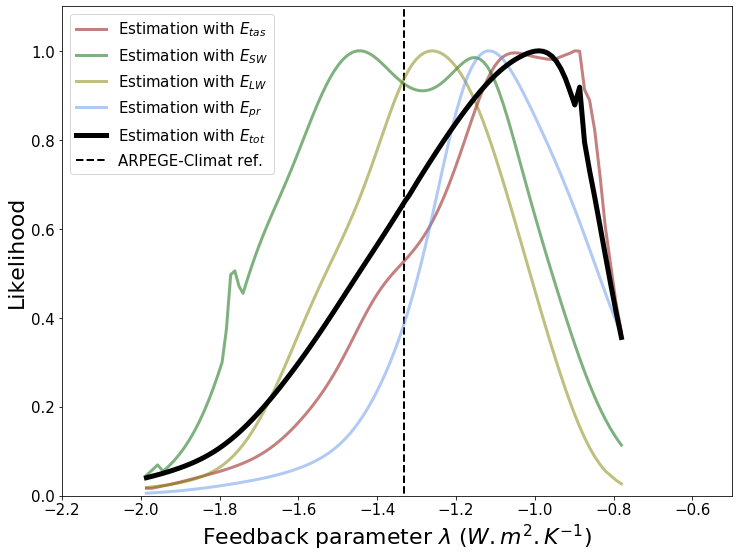

In [34]:
ax = plt.gca()



Likelihood_df.plot(kind='line', x='Fdbck_tas', y='Fdbck_likelihood_tas', color = 'darkred', 
         linewidth=3, figsize=(12, 9), alpha=0.5, ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_SW', y='Fdbck_likelihood_SW', color = 'darkgreen', 
         linewidth=3, alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_LW', y='Fdbck_likelihood_LW', color = 'olive', 
         linewidth=3,  alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_pr', y='Fdbck_likelihood_pr', color = 'cornflowerblue', 
         linewidth=3,  alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_total', y='Fdbck_likelihood_total', color = 'black', 
         linewidth=5,  ax = ax)

plt.vlines(p1_feedbacks,ymin = -1000,ymax = 1000,label='default simulation', colors='black', linewidth=2,
           linestyles='dashed')

#color_list = ['pink', 'orange', 'brown', 'green', 'gray', 'blue', 'red']
#for i in range(1, len(Fdbck_CFMIP), 1) :

#    plt.vlines(Fdbck_CFMIP[i],ymin = -1000,ymax = 1000, colors= color_list[i],  linewidth=1.0,
#           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = [ 'Estimation with $E_{tas}$', 'Estimation with $E_{SW}$', 'Estimation with $E_{LW}$', 
          'Estimation with $E_{pr}$', 'Estimation with $E_{tot}$',
                   'ARPEGE-Climat ref.']

#for i in CFMIP_list :
#    legend.append(i)

plt.xlabel('Feedback parameter $\lambda$ ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('Likelihood', fontsize=22)
plt.legend(legend, fontsize=15)#, bbox_to_anchor=(1.35, 0.35))
#plt.title('Feedbacks likelihood', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.0,1.1)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/Feedback_likelihood.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
# now compute integral cutting right limit down by one
# with each iteration, stop as soon as we hit percplt.show()

In [52]:
# now compute integral cutting right limit down by one
# with each iteration, stop as soon as we hit perc

def my_percentile(x, y, perc):
    N = len(Likelihood_df['Fdbck_likelihood_total'])
    for k in range(1, N):
        xx = x[0:k]
        yy = y[0:k]
        v = np.trapz(yy, xx)
        v2 = (100*v)/0.63
        #print(v2)
        #print(f"Integral {k} from {xx[0]} to {xx[-1]} is equal to {v}")
        if v2 >= perc :
            tmp = x[k]
            break
    return x[k]

In [53]:
x = Likelihood_df['Fdbck_total']
y = Likelihood_df['Fdbck_likelihood_total']

perc10 = my_percentile(x,y,10)
perc50 = my_percentile(x,y,50)
perc90 = my_percentile(x,y,90)
print(perc10, perc50, perc90)

-1.549903588845035 -1.1391183931516837 -0.8735222778012017


In [55]:
ECS_perc10 = -6.517/perc10
ECS_perc50 = -6.517/perc50
ECS_perc90 = -6.517/perc90
print(ECS_perc10, ECS_perc50, ECS_perc90)

4.204777669336433 5.721091011417111 7.460599649964686


## Plot

In [89]:
cpt = 6
Lambda = Fdbck_PPE_selection[cpt]
ECS = -6.517/Lambda
ECS

10.123727421774921

In [90]:
OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy')
OSE

array(0.1771445)

In [91]:
OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_pr.npy')
OSE

array(0.21640208)

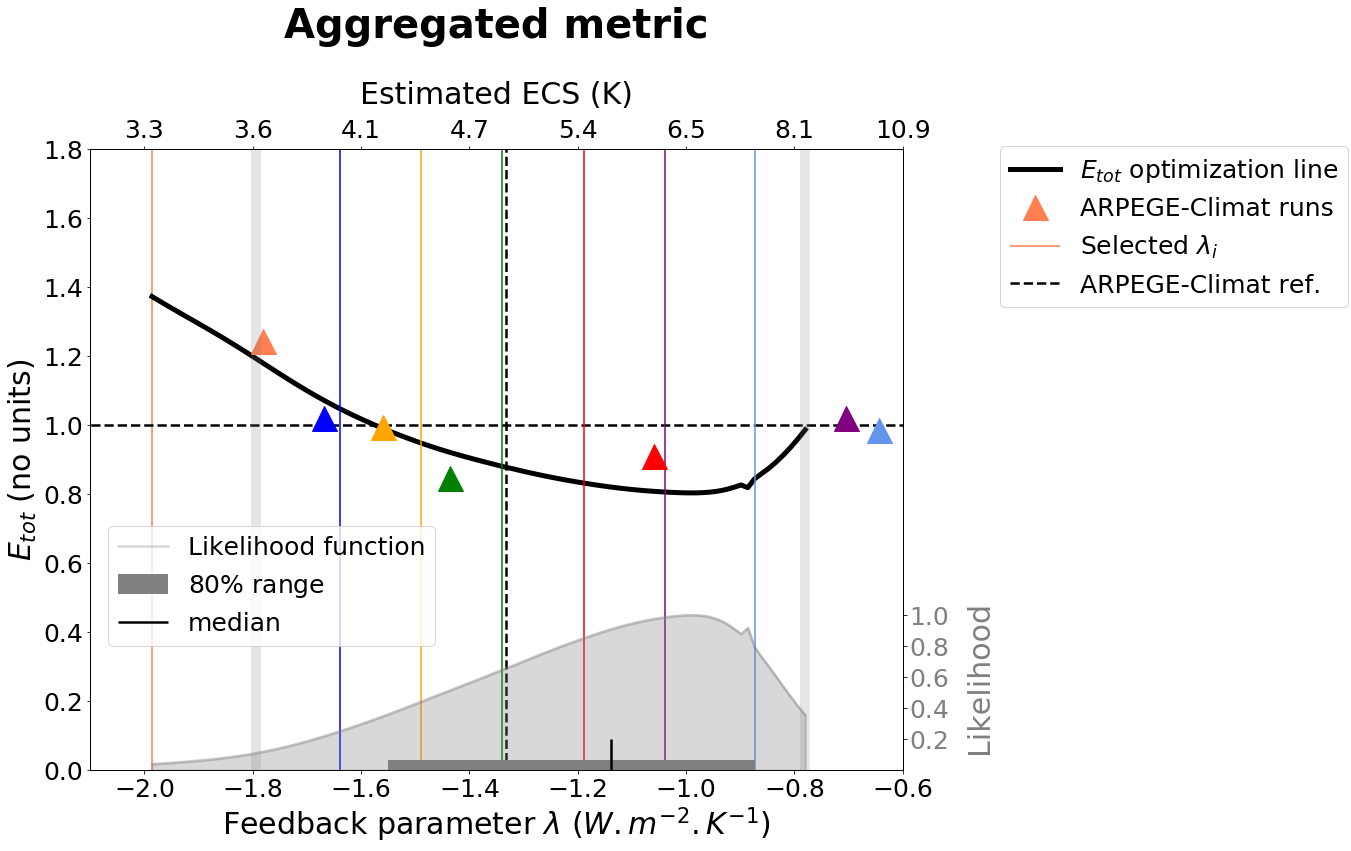

In [54]:
colors = ['coral', 'blue','orange','green','red','purple','cornflowerblue']
cpt=0

fig = plt.figure(figsize=(14, 12))
ax = plt.gca()
ax2 = ax.twiny()

#E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='gray', marker="o", ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)


for i in colors :
    if cpt == 0 :
        #plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)
        ax.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, label='$\lambda$ selection',
           linestyles='solid', linewidth=1.5)

        ax.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', linewidth=0, 
                        label='ARPEGE-Climat simulations', markersize=25, zorder=10)
        cpt+=1
    else :
        #plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')
        plt.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, 
           linestyles='solid', linewidth=1.5)
        
        plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', 
                 linewidth=0, markersize=25, label='_nolegend_', zorder=10)
        cpt+=1

plt.vlines(df_crashed['Fdbck'].iloc[0],ymin = -10,ymax = 25, colors='gray', 
           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)
plt.vlines(df_crashed['Fdbck'].iloc[1],ymin = -10,ymax = 25, colors='gray', 
           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)

ax.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='ARPEGE-Climat default', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

ax3 = ax.twinx()
plt.hlines(0.0, perc10, perc90, color='gray', linestyle='solid', linewidth=20)
plt.vlines(perc50,ymin = 0.0,ymax = 0.2, colors='black', 
           linestyles='solid', linewidth=2.5)
#plt.vlines(perc90, ymin=-10, ymax=0.5, color='olive', linestyle='solid', linewidth=3.5)

       
ax.set_xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
ax.set_ylabel(ylabel, fontsize=30)
ax.set_xlim(-2.1,-0.6)
ax.set_ylim(0.0,1.8)

plt.title('Aggregated metric', fontsize=40, fontweight='bold', y=1.17)
ax.tick_params(axis='both', which='major', labelsize=25)

#plt.ylim(0.5,1.6)

# Second axis

new_tick_locations = np.array([-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6])#df_select['Fdbck'])
new_tick_locations_ax3 = np.array([ 0.2, 0.4, 0.6,0.8,1.0])

def tick_function(X):
    V = -6.517/X
    return ["%.1f" % z for z in V]

def tick_function_ax3(X):
    V=X*2
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Estimated ECS (K)", fontsize=30, labelpad=15.0)
ax2.tick_params(axis='both', which='major', labelsize=25)

ax3.set_ylim(0.0,4.0)
ax3.set_yticks(new_tick_locations_ax3)
ax3.set_yticklabels((new_tick_locations_ax3), color='gray')
ax3.set_ylabel("Likelihood", fontsize=30, position=(-0.7, 0.15), labelpad=15.0, color= 'gray')
ax3.tick_params(axis='both', which='major', labelsize=25)

Likelihood_df.plot( ax=ax3, x='Fdbck_total', y='Fdbck_likelihood_total', kind='area', linewidth=2.5,
                   color='gray', alpha=0.3)

# Legend

legend = [ '$E_{tot}$ optimization line', 'ARPEGE-Climat runs', 'Selected $\lambda_i$', 
          'ARPEGE-Climat ref.']
ax.get_legend().remove()
ax3.legend([ 'Likelihood function', '$80\%$ range', 'median'], fontsize=25, bbox_to_anchor=(0.44, 0.18))
fig.legend(legend, fontsize=25, bbox_to_anchor=(1.35, 0.83)) #bbox_to_anchor=(1.05, 1)
fig.subplots_adjust(right=0.8)

plt.xlim(-2.1,-0.6)

plt.tight_layout()

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_select.png", orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [93]:
df_RMSE_selection = pd.DataFrame(E_PPE_selection_total, columns=['E_arpege'])
df_RMSE_selection['E_multilinreg'] = df_select['sol_fun'].data

df_fdbck_selection = pd.DataFrame(Fdbck_PPE_selection, columns=['fdbck_arpege'])
df_fdbck_selection['fdbck_multilinreg'] = df_select['Fdbck'].data
df_fdbck_selection

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


,fdbck_arpege,fdbck_multilinreg
0,-1.781610,-1.985856
1,-1.667639,-1.639310
2,-1.559913,-1.490135
3,-1.435194,-1.339147
4,-1.059083,-1.188858
5,-0.704648,-1.039423
6,-0.643735,-0.873522


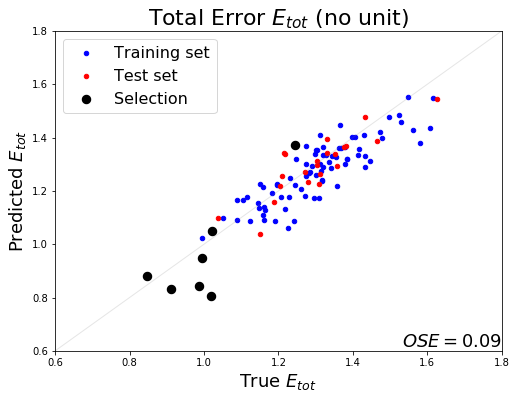

In [69]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"

Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_PPE_total', y='RMSE_multilinreg_val_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_PPE_total', y='RMSE_multilinreg_val_total', color='red',  
                     marker="o", ax = ax)

df_RMSE_selection.plot(kind='scatter', x='E_arpege', y='E_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.09$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set','Test set','Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.6,1.8)
plt.xlim(0.6,1.8)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

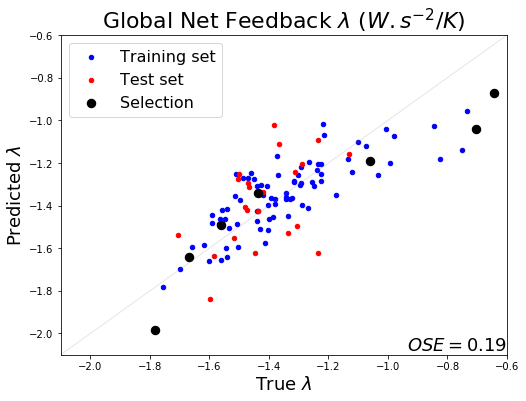

In [70]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)
df_fdbck_selection.plot(kind='scatter', x='fdbck_arpege', y='fdbck_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set', 'Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.1,-0.6)
plt.xlim(-2.1,-0.6)
ax.plot((-4.0,0.6), (-4.0,0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# Retour aux paramètres

In [ ]:
param_names = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy')
E_emulator_df = E_multilinreg_df.reset_index()

x_emulator = pd.DataFrame(LHS, columns= param_names)
x_emulator['RMSE_total'] = E_emulator_df['RMSE_total']

x_emulator['RMSE_total_round'] = x_emulator['RMSE_total'].round(decimals=1)
x_emulator['members'] = range(0,100000,1) 

#x_emulator = x_emulator.set_index('RMSE_total_round')
#x_emulator_new_df=pd.DataFrame()
#x_emulator_new_df['RMSE_total_best'] = x_emulator['RMSE_total'].groupby('RMSE_total_round').min()
#x_emulator_new_df = x_emulator_new_df.reset_index()
#x_emulator_new_df

In [ ]:
x_emulator

In [ ]:
x_init1 = pd.DataFrame(x_best, columns=[i+'_init1' for i in param_names])
x_init1['members'] = range(0, len(x_init1), 1)
x_init1 = x_init1.set_index('members')

#x_init1

x_optim1 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_optim1[param_names[i]+'_optim1'] = sol_df['x'+str(j)+'_smth_0']
x_optim1['members'] = range(0, len(x_init1), 1)
x_optim1 = x_optim1.set_index('members')
#x_optim1

x_init2 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_init2[param_names[i]+'_init2'] = new_sol_df['x'+str(j)+'_smth_150']
x_init2['members'] = range(0, len(x_init1), 1)
x_init2 = x_init2.set_index('members')
#x_init2

x_optim2 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_optim2[param_names[i]+'_optim2'] = sol_df_2['x'+str(j)+'_smth_0']
x_optim2['members'] = range(0, len(x_init1), 1)
x_optim2 = x_optim2.set_index('members')
#x_optim2

X = x_init1.merge(x_optim1, on = ['members']).merge(x_init2, on = ['members']).merge(x_optim2, on = ['members'])
X['Fdbck'] = sol_df_2['Fdbck']
X

In [ ]:
sol_df_2['RMSE'] = sol_df_2['sol_fun'].round(decimals=2)
sol_df_2

In [ ]:
def plot_param(df, param_y, xlabel, ylabel, hue, colors, param_names, ax):
    
    sns.scatterplot(data=df, x="Fdbck", y=param_y+'_smth_0', hue=hue, legend = 'full', palette=colors, ax=ax)
    
    plt.plot(p1_feedbacks, p1_params[ylabel], color='black', marker='+', linewidth=0, markersize=50)
    
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    #plt.legend(legend, fontsize=15)
    #plt.title('Param 1 et 2', fontsize=30)
    #ax.legend([None])
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(-2.2,-0.5) 
    ind = df[param_y+'_smth_0'].max() - df[param_y+'_smth_0'].min()
    if p1_params[ylabel]<df[param_y+'_smth_0'].min() :
        lim_min = p1_params[ylabel]
    else :
        lim_min = df[param_y+'_smth_0'].min()
    
    if p1_params[ylabel]>df[param_y+'_smth_0'].max() :
        lim_max = p1_params[ylabel]
    else :
        lim_max = df[param_y+'_smth_0'].max()
        
    plt.ylim(lim_min-ind/10,lim_max+ind/10)

    # Show la figure .................
    #plt.show()

In [ ]:
# READ FROM ROMAIN REF NAMELIST 

p1_params = {}
p1_params['AKN'] = 0.126
p1_params['ALPHAT'] = 1.13
p1_params['ALD'] = 1.18
p1_params['ALMAVE'] = 10.0
p1_params['AGREF'] = -0.36
p1_params['AGRE1'] = 5.5
p1_params['AGRE2'] = 0.0
p1_params['RAUTEFR'] = 0.001
p1_params['RQLCR'] = 0.0002
p1_params['RAUTEFS'] = 0.0052
p1_params['RQICRMIN'] = 0.0000001
p1_params['RQICRMAX'] = 0.000021
p1_params['TFVL'] = 0.02
p1_params['TFVI'] = 0.04
p1_params['TFVR'] = 3.0
p1_params['TFVS'] = 0.6
p1_params['RKDN'] = 0.00005
p1_params['RKDX'] = 0.0001
p1_params['TENTR'] = 0.000004
p1_params['TENTRX'] = 0.00006
p1_params['VVN'] = -2.0
p1_params['VVX'] = -35.0
p1_params['ALFX'] = 0.04
p1_params['FNEBC'] = 10.0
p1_params['GCTURB'] = 0.00005
p1_params['RLWINHF_ICE'] = 0.9
p1_params['RLWINHF_LIQ'] = 0.9
p1_params['RSWINHF_ICE'] = 0.71
p1_params['RSWINHF_LIQ'] = 0.71
p1_params['REFLCAPE'] = 2.0

np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_params', p1_params)
#p1_params

In [ ]:
df=sol_df_2
hue = df['RMSE']
legend = df['RMSE']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')

plt.subplots(figsize=(25,25)) 
ax={}

for i in range(0, 30, 1) :
    
    plt.subplot(6,5,(i+1))
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    plot_param(df, param_y, xlabel, ylabel, hue, colors, param_names, ax[str(i)])
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 7.5), loc=2)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()